# Food Spoilage Prediction Case Study

## Basic Imports and Data Setup

In [29]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn import tree
import matplotlib.pyplot as plt
import os


In [9]:
quantized_train_df = pd.read_csv("quantized_train.csv")
quantized_test_df = pd.read_csv("quantized_test.csv")

# Separate features and labels
sensor_cols = [col for col in quantized_train_df.columns if col != "Label"]
X_train = quantized_train_df[sensor_cols].values
y_train = quantized_train_df["Label"].values

X_test = quantized_test_df[sensor_cols].values
y_test = quantized_test_df["Label"].values

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4440, 11)
y_train shape: (4440,)
X_test shape: (555, 11)
y_test shape: (555,)


## K-Nearest Neighbors (KNN)

In [11]:
class IntegerKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Store as integer arrays
        self.X_train_ = np.asarray(X, dtype=np.int32)
        self.y_train_ = np.asarray(y)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.int32)
        preds = []
        for x in X:
            # Compute L1 (Manhattan) distance, all integer math
            dists = np.sum(np.abs(self.X_train_ - x), axis=1)
            # Get indices of k smallest distances
            knn_idx = np.argpartition(dists, self.n_neighbors)[:self.n_neighbors]
            knn_labels = self.y_train_[knn_idx]
            # Tally votes using integer counts
            labels, counts = np.unique(knn_labels, return_counts=True)
            # Pick label with highest count (break ties by smallest label)
            max_count = np.max(counts)
            candidates = labels[counts == max_count]
            pred = np.min(candidates)
            preds.append(pred)
        return np.array(preds)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Try integer-only KNN on quantized data
int_knn = IntegerKNNClassifier(n_neighbors=3)
int_knn.fit(X_train, y_train)
int_knn_acc = int_knn.score(X_test, y_test)
print(f"Integer-only KNN (L1, k=3) test accuracy: {int_knn_acc:.3f}")


Integer-only KNN (L1, k=3) test accuracy: 0.989



Integer-only KNN (k=3) test accuracy vs. fraction of training data kept:
  Fraction 0.01: test accuracy = 0.813 ± 0.036
  Fraction 0.10: test accuracy = 0.943 ± 0.013
  Fraction 0.20: test accuracy = 0.969 ± 0.004
  Fraction 0.40: test accuracy = 0.980 ± 0.004
  Fraction 0.60: test accuracy = 0.983 ± 0.002
  Fraction 0.80: test accuracy = 0.987 ± 0.001
  Fraction 1.00: test accuracy = 0.989 ± 0.000


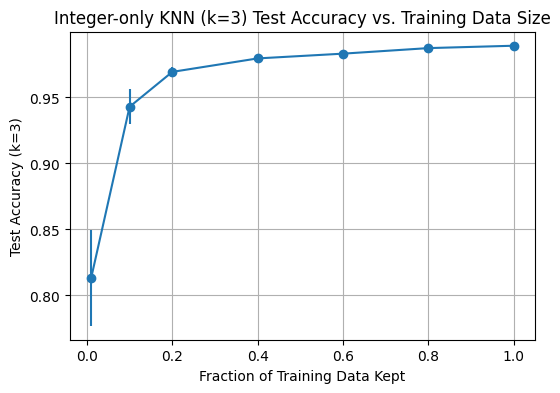

In [12]:
# Sweep: try different fractions of training data kept, for k=5 (using IntegerKNNClassifier)
fractions = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
accs = []
stds = []
n_repeats = 3  # repeat for stability

print("\nInteger-only KNN (k=3) test accuracy vs. fraction of training data kept:")
for frac in fractions:
    accs_frac = []
    for _ in range(n_repeats):
        # Randomly sample a fraction of the training data
        n_samples = int(len(X_train) * frac)
        idx = np.random.choice(len(X_train), n_samples, replace=False)
        X_train_sub = X_train[idx]
        y_train_sub = y_train[idx]
        int_knn5 = IntegerKNNClassifier(n_neighbors=3)
        int_knn5.fit(X_train_sub, y_train_sub)
        acc = int_knn5.score(X_test, y_test)
        accs_frac.append(acc)
    mean_acc = np.mean(accs_frac)
    std_acc = np.std(accs_frac)
    accs.append(mean_acc)
    stds.append(std_acc)
    print(f"  Fraction {frac:.2f}: test accuracy = {mean_acc:.3f} ± {std_acc:.3f}")

# Optionally, plot the results
plt.figure(figsize=(6,4))
plt.errorbar(fractions, accs, yerr=stds, fmt='-o')
plt.xlabel('Fraction of Training Data Kept')
plt.ylabel('Test Accuracy (k=3)')
plt.title('Integer-only KNN (k=3) Test Accuracy vs. Training Data Size')
plt.grid(True)
plt.show()


In [38]:
portion = 1

# Use a random seed for reproducibility
np.random.seed(42)

# Load the quantized training data
train_csv = "quantized_train.csv"
data = np.genfromtxt(train_csv, delimiter=",", skip_header=1)
X = data[:, :-1].astype(np.uint8)
y = data[:, -1].astype(np.int8)

# Decide on a random portion (e.g., 30%) of the training data
n_total = X.shape[0]
n_select = int(n_total * portion)
indices = np.random.choice(n_total, n_select, replace=False)
X_sub = X[indices]
y_sub = y[indices]

# Write the header file
header_guard = "KNN_TRAINING_H"
num_samples = X_sub.shape[0]
num_features = X_sub.shape[1]

header_lines = []
header_lines.append(f"#ifndef {header_guard}")
header_lines.append(f"#define {header_guard}")
header_lines.append("")
header_lines.append(f"#define Num_Training_Samples {num_samples}")
header_lines.append(f"#define Num_Features {num_features}")
header_lines.append("")
header_lines.append(f"unsigned char Training_Data[Num_Training_Samples][Num_Features] = {{")
for row in X_sub:
    row_str = ", ".join(str(int(x)) for x in row)
    header_lines.append(f"    {{{row_str}}},")
header_lines.append("};")
header_lines.append("")
header_lines.append("char Training_Labels[Num_Training_Samples] = {")
label_lines = []
for label in y_sub:
    label_lines.append(f"    {int(label)},")
header_lines.extend(label_lines)
header_lines.append("};")
header_lines.append("")
header_lines.append(f"#endif // {header_guard}")

# Write to file
out_path = os.path.join("C-source", "knn_training.h")
with open(out_path, "w") as f:
    f.write("\n".join(header_lines))

print(f"Wrote {out_path} with {num_samples} samples and {num_features} features.")


Wrote C-source/knn_training.h with 4440 samples and 11 features.


## Decision Tree Small


In [39]:
# Train a decision tree of size 3 (max_depth=3)
small_dt = DecisionTreeClassifier(max_depth=3, random_state=42)
small_dt.fit(X_train, y_train)

train_acc = small_dt.score(X_train, y_train)
print(f"Decision Tree (max_depth=3) train accuracy: {train_acc:.3f}")

best_depth = 3
best_dt_acc = small_dt.score(X_test, y_test)
print(f"Decision Tree (max_depth=3) test accuracy: {best_dt_acc:.3f}")

Decision Tree (max_depth=3) train accuracy: 0.912
Decision Tree (max_depth=3) test accuracy: 0.838


In [40]:
# Display the decision tree nodes, features, and thresholds (split points)
print("Decision Tree (max_depth=3) nodes and thresholds:")
tree = small_dt.tree_
for i in range(tree.node_count):
    if tree.children_left[i] != tree.children_right[i]:  # not a leaf
        feature = tree.feature[i]
        threshold = tree.threshold[i]
        print(f"Node {i}: feature {feature} (X[:, {feature}]) <= {threshold:.3f}")
    else:
        print(f"Node {i}: leaf node (value = {tree.value[i].flatten()})")


Decision Tree (max_depth=3) nodes and thresholds:
Node 0: feature 6 (X[:, 6]) <= 27.500
Node 1: feature 1 (X[:, 1]) <= 32.500
Node 2: feature 2 (X[:, 2]) <= 112.500
Node 3: leaf node (value = [0. 1. 0. 0.])
Node 4: leaf node (value = [0.00000000e+00 3.69276219e-04 3.61890694e-02 9.63441654e-01])
Node 5: feature 10 (X[:, 10]) <= 54.500
Node 6: leaf node (value = [0. 0. 0. 1.])
Node 7: leaf node (value = [0. 0. 1. 0.])
Node 8: feature 3 (X[:, 3]) <= 145.500
Node 9: feature 2 (X[:, 2]) <= 149.500
Node 10: leaf node (value = [0.17632242 0.71662469 0.09571788 0.01133501])
Node 11: leaf node (value = [0.         0.09574468 0.84840426 0.05585106])
Node 12: feature 6 (X[:, 6]) <= 46.500
Node 13: leaf node (value = [0.08333333 0.91666667 0.         0.        ])
Node 14: leaf node (value = [0.98283262 0.01716738 0.         0.        ])


In [52]:
# Convert the trained decision tree (max_depth=3) to a C implementation
# Output to C-source/decision_tree_small.c

import os

def generate_c_decision_tree(tree, feature_names=None, node=0, indent=1):
    """Recursively generate the decision tree as nested C if-else statements."""
    lines = []
    space = "    " * indent
    if tree.children_left[node] == tree.children_right[node]:
        # Leaf node: output the predicted class (argmax of value)
        values = tree.value[node][0]
        pred_class = values.argmax()
        lines.append(f"{space}return {pred_class};")
    else:
        feature = tree.feature[node]
        threshold = tree.threshold[node]
        fname = feature_names[feature] if feature_names else f"feature_{feature}"
        lines.append(f"{space}if ({fname} <= {int(threshold)}) {{")
        lines.extend(generate_c_decision_tree(tree, feature_names, tree.children_left[node], indent + 1))
        lines.append(f"{space}}} else {{")
        lines.extend(generate_c_decision_tree(tree, feature_names, tree.children_right[node], indent + 1))
        lines.append(f"{space}}}")
    return lines

# Prepare feature names for C variable names
c_feature_names = [
    "MQ135", "MQ136", "MQ137", "MQ138", "MQ2", "MQ3", "MQ4", "MQ5", "MQ6", "MQ8", "MQ9"
]

c_lines = []
c_lines.append("// C implementation of the decision tree (max_depth=3)")
c_lines.append("char kernel_predict(")
for i, fname in enumerate(c_feature_names):
    comma = "," if i < len(c_feature_names) - 1 else ""
    c_lines.append(f"    unsigned char {fname}{comma}")
c_lines.append(") {")
c_lines.extend(generate_c_decision_tree(small_dt.tree_, c_feature_names))
c_lines.append("}")

# Write to file
os.makedirs("C-source", exist_ok=True)
out_path = os.path.join("C-source", "decision_tree_small.c")
with open(out_path, "w") as f:
    f.write("\n".join(c_lines) + "\n")

print(f"Wrote {out_path} with decision tree C implementation.")


Wrote C-source/decision_tree_small.c with decision tree C implementation.


## Decision Tree Large

In [42]:
# Define the search space for max_depth
search_space_dt = {'max_depth': Integer(1, 10)}

dt = DecisionTreeClassifier(random_state=42)
bayes_search_dt = BayesSearchCV(
    dt,
    search_spaces=search_space_dt,
    n_iter=8,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
bayes_search_dt.fit(X_train, y_train)
best_depth = bayes_search_dt.best_params_['max_depth']
best_dt_acc = bayes_search_dt.score(X_test, y_test)
print(f'Best Decision Tree (BayesSearch): max_depth={best_depth}, accuracy={best_dt_acc:.3f}')

# Train the final decision tree
final_dt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_dt.fit(X_train, y_train)

train_acc = final_dt.score(X_train, y_train)
print(f"Decision Tree train accuracy: {train_acc:.3f}")

Best Decision Tree (BayesSearch): max_depth=5, accuracy=0.951
Decision Tree train accuracy: 0.951


In [53]:
# Prepare feature names for C variable names
c_feature_names = [
    "MQ135", "MQ136", "MQ137", "MQ138", "MQ2", "MQ3", "MQ4", "MQ5", "MQ6", "MQ8", "MQ9"
]

c_lines = []
c_lines.append("// C implementation of the decision tree (max_depth=3)")
c_lines.append("char kernel_predict(")
for i, fname in enumerate(c_feature_names):
    comma = "," if i < len(c_feature_names) - 1 else ""
    c_lines.append(f"    unsigned char {fname}{comma}")
c_lines.append(") {")
c_lines.extend(generate_c_decision_tree(final_dt.tree_, c_feature_names))
c_lines.append("}")

# Write to file
os.makedirs("C-source", exist_ok=True)
out_path = os.path.join("C-source", "decision_tree_large.c")
with open(out_path, "w") as f:
    f.write("\n".join(c_lines) + "\n")

print(f"Wrote {out_path} with decision tree C implementation.")

Wrote C-source/decision_tree_large.c with decision tree C implementation.


## Linear Discriminant

In [45]:
# Quick Bayes search for C (regularization strength)
search_space_logreg = {'C': Real(1e-5, 1e3, prior='log-uniform')}
logreg = LogisticRegression(random_state=42, max_iter=200)
bayes_search_logreg = BayesSearchCV(
    logreg,
    search_spaces=search_space_logreg,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1

)
bayes_search_logreg.fit(X_train, y_train)
best_C = bayes_search_logreg.best_params_['C']
best_logreg_acc = bayes_search_logreg.score(X_test, y_test)
print(f'Best LogisticRegression (BayesSearch): C={best_C:.4f}, accuracy={best_logreg_acc:.3f}')


/Users/andy/research/Flexibench/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andy/research/Flexibench/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Best LogisticRegression (BayesSearch): C=6.3637, accuracy=0.987


/Users/andy/research/Flexibench/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andy/research/Flexibench/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [46]:
# Train the final logistic regression with best C
print(best_C)
linear_clf = LogisticRegression(random_state=42, max_iter=200, C=best_C)
linear_clf.fit(X_train, y_train)
linear_acc = linear_clf.score(X_test, y_test)
print(f'Linear Discriminator (LogisticRegression) accuracy: {linear_acc:.3f}')

6.363703576331173
Linear Discriminator (LogisticRegression) accuracy: 0.987


/Users/andy/research/Flexibench/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
# Symmetic Quantization
def quantize_to_int8(arr):
    """
    Quantize a numpy array to uint8, scaling to use the full uint8 range (0 to 255).
    Returns the quantized aray, the scale, and the zero point used for dequantization.
    """
    arr = np.asarray(arr)
    arr_min = arr.min()
    arr_max = arr.max()
    # Avoid division by zero if all values are the same
    if arr_max == arr_min:
        scale = 1.0
        zero_point = 0
        quantized = np.zeros_like(arr, dtype=np.uint8)
    else:
        scale = max(abs(arr_max), abs(arr_min)) / 128.0
        quantized = np.round((arr) / scale).astype(np.int8)
        quantized = np.clip(quantized, -128, 127)
    return quantized, scale

# Extract coefficients and intercept from the trained logistic regression model
coef = linear_clf.coef_
intercept = linear_clf.intercept_

# Quantize coefficients to uint8
coef_q, coef_scale = quantize_to_int8(coef)

print(coef_q)
print(coef_scale)



# Quantize intercept using the same scale and zero point as coef
intercept = np.asarray(intercept)
intercept_q = np.round(intercept / coef_scale).astype(np.int16)
print(intercept_q)

[[  -1   -7  -61  -30    8   10  108   10  -10    1   20]
 [   8   44  -21  -19   -2  -26   38   -1   18    8    7]
 [   5   29   43   32  -28  -27  -18   -6   -6   -3  -15]
 [ -12  -66   40   16   21   43 -128   -3   -3   -5  -12]]
0.010428390398605976
[ 0  2 -1 -2]


In [48]:
def linear_logreg_predict_quantized(x_q, coef_q, intercept_q):
    """
    Predict class for quantized input x_q using quantized coefficients and quantized intercepts.
    x_q: quantized input vector (uint8, shape: (n_features,))
    coef_q: quantized coefficients (uint8, shape: (n_classes, n_features))
    intercept_q: quantized intercepts (int32, shape: (n_classes,))
    Returns: predicted class index (int)
    """
    # Compute dot product in int32 for each class
    logits = np.dot(coef_q, x_q.astype(np.int16)) + intercept_q
    # Return the index of the class with the highest score
    return np.argmax(logits)

# Example usage:
# y_pred_q_indices = [linear_logreg_predict_quantized(x, coef_q, intercept_q) for x in X_test.astype(np.uint8)]
# y_pred_q = [classes[idx] for idx in y_pred_q_indices]
# Evaluate the quantized logistic regression on the test set

# Ensure X_test is quantized to uint8 (if not already)
X_test_q = X_test.astype(np.uint8)

# Predict class indices for all test samples using quantized model
y_pred_q_indices = [linear_logreg_predict_quantized(x, coef_q, intercept_q) for x in X_test_q]

# Map indices to class labels
classes = linear_clf.classes_

y_pred_q = [classes[idx] for idx in y_pred_q_indices]

# Compute accuracy
from sklearn.metrics import accuracy_score
quantized_accuracy = accuracy_score(y_test, y_pred_q)

print("Quantized logistic regression test accuracy:", quantized_accuracy)

Quantized logistic regression test accuracy: 0.9819819819819819


In [51]:
import numpy as np

# Write the quantized logistic regression model to a C file
def write_quantized_logreg_to_c(coef_q, intercept_q, filename="C-source/linear_discriminant.c"):
    """
    Write the quantized logistic regression model to a C file.
    coef_q: quantized coefficients (shape: n_classes, n_features), dtype: int16 or int8
    intercept_q: quantized intercepts (shape: n_classes,), dtype: int16 or int32
    filename: output C file path
    """
    n_classes, n_features = coef_q.shape

    with open(filename, "w") as f:
        f.write("// Quantized logistic regression (linear discriminant) model\n")
        f.write(f"#define N_CLASSES {n_classes}\n")
        f.write(f"#define N_FEATURES {n_features}\n\n")

        # Write quantized coefficients
        f.write(f"const short coef_q[N_CLASSES][N_FEATURES] = {{\n")
        for i in range(n_classes):
            row = ", ".join(str(int(v)) for v in coef_q[i])
            f.write(f"    {{{row}}}")
            if i < n_classes - 1:
                f.write(",\n")
            else:
                f.write("\n")
        f.write("};\n\n")

        # Write quantized intercepts
        f.write(f"const long intercept_q[N_CLASSES] = {{")
        f.write(", ".join(str(int(v)) for v in intercept_q))
        f.write("};\n\n")

        # Write the prediction function
        f.write(
"""// Predict class for quantized input x_q (uint8_t[N_FEATURES])
char kernel_predict(
    unsigned char MQ135,
    unsigned char MQ136,
    unsigned char MQ137,
    unsigned char MQ138,
    unsigned char MQ2,
    unsigned char MQ3,
    unsigned char MQ4,
    unsigned char MQ5,
    unsigned char MQ6,
    unsigned char MQ8,
    unsigned char MQ9
) {
    unsigned char x_q[N_FEATURES] = {
        MQ135, MQ136, MQ137, MQ138, MQ2, MQ3, MQ4, MQ5, MQ6, MQ8, MQ9
    };
    long logits[N_CLASSES] = {0};
    for (int c = 0; c < N_CLASSES; ++c) {
        long sum = intercept_q[c];
        for (int f = 0; f < N_FEATURES; ++f) {
            sum += coef_q[c][f] * (short)x_q[f];
        }
        logits[c] = sum;
    }
    // Argmax over logits
    int max_idx = 0;
    long max_val = logits[0];
    for (int c = 1; c < N_CLASSES; ++c) {
        if (logits[c] > max_val) {
            max_val = logits[c];
            max_idx = c;
        }
    }
    return max_idx;
}
"""
        )

# Actually write the file using the trained quantized model
write_quantized_logreg_to_c(coef_q, intercept_q, filename="C-source/linear_discriminant.c")


## Mock Pareto

In [33]:
# -------------------------
# 1) Define Internal Data
# -------------------------
system_specs = {
    "Serv": {"area": 2.93, "power": 17.7451},
    "Qerv": {"area": 3.68, "power": 21.0650},
    "Herv": {"area": 4.50, "power": 24.9934},
}
# In number of cycles
execution_time = {
    "Food Spoilage Detection":  {"Serv": 6171.3, "Qerv": 1963.5, "Herv": 1256.9},
    "Cardiotocography": {"Serv": 415615.7, "Qerv": 131434.4, "Herv": 83432.6},
    "Arrhythmia Detection": {"Serv": 163598847500.00, "Qerv": 51856949500.00, "Herv": 33142273500.00},
    "Water Quality Detection": {"Serv": 4376.9, "Qerv": 1401.05, "Herv": 900.65},
    "Smart HVAC Monitoring": {"Serv": 122917500.00, "Qerv": 39156450.00, "Herv": 25083150.00},
    "Gesture Recognition": {"Serv": 21818684300.00, "Qerv": 6905954100.00, "Herv": 4403825300.00},
    "Air Pollution Monitoring": {"Serv": 1460624.9, "Qerv": 461267.6, "Herv": 292341.2},
    "Odor Detection": {"Serv": 5359.7, "Qerv": 1708.65, "Herv": 1094.65},
    "Smart Irrigation": {"Serv": 1130791.65, "Qerv": 357050.15, "Herv": 226125.75},
}

rf_sram = 128 # Implementing register file in SRAM for space-saving


# Define SRAM and LPROM constants (in bits)
sram_power = 0.0018
sram_area = 0.00176
lprom_power = 0 # negligible
lprom_area = 0.000359
sram_overhead_power = 0.0002 # per bit
sram_overhead_area = 0.0003 # per bit

# In bytes
sram = {
    "Food Spoilage Detection": 49,
    "Cardiotocography": 590,
    "Arrhythmia Detection": 4170,
    "Water Quality Detection": 13,
    "Smart HVAC Monitoring": 63,
    "Gesture Recognition": 40033,
    "Air Pollution Monitoring": 591,
    "Odor Detection": 21,
    "Smart Irrigation": 77,
    # "Animal Tracking": 39193
}

# In bytes
lprom = {
    "Food Spoilage Detection": 1676,
    "Cardiotocography": 4256,
    "Arrhythmia Detection": 3970,
    "Water Quality Detection": 368,
    "Smart HVAC Monitoring": 102432,
    "Gesture Recognition": 200508,
    "Air Pollution Monitoring": 3373,
    "Odor Detection": 1188,
    "Smart Irrigation": 1348,
    # "Animal Tracking": 3448
}

# Define carbon intensity values for each power source
# gCO2 eq / kWhr
# Source: https://www.eia.gov/tools/faqs/faq.php?id=74&t=11
# And: https://www.energy.gov/eere/wind/articles/how-wind-can-help-us-breathe-easier
carbon_intensity_values = {
    "US Avg (2023)": "367",
    "Petroleum": "1116",
    "Coal": "1048",
    "Solar": "28",
    "Nuclear": "13",
    "Wind": "12",
    "Custom": ""
}

embodied_values = {
    "Food Spoilage Detection": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 0.87, "Carbon Footprint Max (gCO2e)": 1.17},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 0.93, "Carbon Footprint Max (gCO2e)": 1.25},
        "Herv": {"Carbon Footprint Min (gCO2e)": 1.0, "Carbon Footprint Max (gCO2e)": 1.34},
    },
    "Cardiotocography": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 2.2, "Carbon Footprint Max (gCO2e)": 2.96},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 2.26, "Carbon Footprint Max (gCO2e)": 3.04},
        "Herv": {"Carbon Footprint Min (gCO2e)": 2.32, "Carbon Footprint Max (gCO2e)": 3.13},
    },
    "Arrhythmia Detection": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 6.93, "Carbon Footprint Max (gCO2e)": 9.34},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 6.99, "Carbon Footprint Max (gCO2e)": 9.42},
        "Herv": {"Carbon Footprint Min (gCO2e)": 7.06, "Carbon Footprint Max (gCO2e)": 9.51},
    },
    "Water Quality Detection": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 0.51, "Carbon Footprint Max (gCO2e)": 0.69},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 0.58, "Carbon Footprint Max (gCO2e)": 0.77},
        "Herv": {"Carbon Footprint Min (gCO2e)": 0.64, "Carbon Footprint Max (gCO2e)": 0.86},
    },
    "Smart HVAC Monitoring": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 24.44, "Carbon Footprint Max (gCO2e)": 32.92},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 24.5, "Carbon Footprint Max (gCO2e)": 33.0},
        "Herv": {"Carbon Footprint Min (gCO2e)": 24.57, "Carbon Footprint Max (gCO2e)": 33.09},
    },
    "Gesture Recognition": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 100.99, "Carbon Footprint Max (gCO2e)": 136.02},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 101.05, "Carbon Footprint Max (gCO2e)": 136.1},
        "Herv": {"Carbon Footprint Min (gCO2e)": 101.12, "Carbon Footprint Max (gCO2e)": 136.19},
    },
    "Air Pollution Monitoring": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 1.99, "Carbon Footprint Max (gCO2e)": 2.68},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 2.05, "Carbon Footprint Max (gCO2e)": 2.76},
        "Herv": {"Carbon Footprint Min (gCO2e)": 2.12, "Carbon Footprint Max (gCO2e)": 2.85},
    },
    "Odor Detection": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 0.72, "Carbon Footprint Max (gCO2e)": 0.96},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 0.78, "Carbon Footprint Max (gCO2e)": 1.05},
        "Herv": {"Carbon Footprint Min (gCO2e)": 0.84, "Carbon Footprint Max (gCO2e)": 1.14},
    },
    "Smart Irrigation": {
        "Serv": {"Carbon Footprint Min (gCO2e)": 0.83, "Carbon Footprint Max (gCO2e)": 1.12},
        "Qerv": {"Carbon Footprint Min (gCO2e)": 0.89, "Carbon Footprint Max (gCO2e)": 1.2},
        "Herv": {"Carbon Footprint Min (gCO2e)": 0.96, "Carbon Footprint Max (gCO2e)": 1.29},
    }
}
    

In [36]:
def compute_total_carbon(
    system: str,
    workload: str,
    lifetime_yrs: float,
    inf_freq: float, # per year
    carbon_intensity: float,
    
    core_freq: float  # New input for core frequency
):
    """
    Compute the total carbon footprint of a given system with the user-specified parameters.
    Returns (embodied_carbon, operational_carbon, total_carbon).
    """
    
    sram_bytes = sram[workload] + rf_sram
    lprom_bytes = lprom[workload]

    # 1) Calculate total area
    core_area = system_specs[system]["area"]
    device_area = core_area + (sram_area + sram_overhead_area) * sram_bytes * 8 + lprom_area * lprom_bytes * 8
    # 2) Embodied carbon (simplified)

    embodied_carbon = embodied_values[workload][system]["Carbon Footprint Max (gCO2e)"]
    # 3) Operational carbon
    #    - power_of_system + power_of_sram + power_of_lprom
    #    - execution_time * inferences
    #    - carbon intensity factor
    system_power = system_specs[system]["power"]
    total_power = system_power + (sram_power + sram_overhead_power) * sram_bytes * 8 + lprom_power * lprom_bytes * 8
    
    # Convert lifetime in years to total inferences:
    # For example: inferences_per_day * 365 * lifetime_years
    total_inferences = inf_freq * lifetime_yrs    # Execution time of each inference
    time_per_inference = execution_time[workload][system] / core_freq  # Adjusted with core frequency
    total_energy = total_power * time_per_inference * total_inferences  # (Power * Time)
    operational_carbon = total_energy * carbon_intensity
    
    total_carbon = embodied_carbon + operational_carbon

    return embodied_carbon, operational_carbon, total_carbon


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown

# Example: user-provided accuracy values for each workload (update as needed)
workload_accuracies = {
    # "ECG Classification": 0.92,
    "Cardiotocography": 0.97,
    # "Arrhythmia Detection": 0.7,
    "Water Quality Detection": 0.85,
    # "Smart HVAC Monitoring": 0.91,
    # "Gesture Recognition": 0.97,
    # "Air Pollution Monitoring": 0.93,
    "Odor Detection": 0.95,
    "Smart Irrigation": 0.99
}

def plot_accuracy_vs_carbon(lifetime_years, tasks_per_year, carbon_intensity):
    x_acc = []
    y_cf = []
    labels = []
    colors = []
    carbon_intensity = float(carbon_intensity) / 3600 / 1000000
    variant_color_map = {
        'Serv': 'tab:blue',
        'Qerv': 'tab:orange',
        'Herv': 'tab:green'
    }
    for workload, acc in workload_accuracies.items():
        for variant in ['Serv', 'Qerv', 'Herv']:
            footprint = compute_total_carbon(variant,workload,lifetime_years,tasks_per_year,carbon_intensity,10000)[2]
            x_acc.append(acc)
            y_cf.append(footprint)
            workload_name_map = {
                "Cardiotocography": "MLP",
                "Water Quality Detection": "Small DT",
                "Odor Detection": "Large DT",
                "Smart Irrigation": "KNN"
            }
            display_name = workload_name_map.get(workload, workload)
            if variant == 'Serv':
                labels.append(f"{display_name}")
            else:
                labels.append("")
            colors.append(variant_color_map[variant])

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x_acc, y_cf, c=colors, s=100)

    for i, label in enumerate(labels):
        plt.annotate(label, (x_acc[i], y_cf[i]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

    # Custom legend for the variants
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Serv', markerfacecolor='tab:blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Qerv', markerfacecolor='tab:orange', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Herv', markerfacecolor='tab:green', markersize=10)
    ]
    plt.legend(handles=legend_elements, title="Variant")

    plt.xlabel("Accuracy")
    plt.ylabel(f"Total Carbon Footprint over {lifetime_years} years (gCO2e)")
    plt.title("Accuracy vs. Carbon Footprint for All Variants")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Reasonable slider ranges for interactive exploration
interact(
    plot_accuracy_vs_carbon,
    lifetime_years=FloatSlider(value=1, min=0.1, max=10, step=0.1, description='Lifetime (years)'),
    tasks_per_year=IntSlider(value=365, min=1, max=10000, step=1, description='Tasks/year'),
    carbon_intensity=Dropdown(
        options=carbon_intensity_values,
        value=carbon_intensity_values["US Avg (2023)"],
        description='Carbon Intensity\n(gCO2e/Wh)'
    )
)


interactive(children=(FloatSlider(value=1.0, description='Lifetime (years)', max=10.0, min=0.1), IntSlider(val…

<function __main__.plot_accuracy_vs_carbon(lifetime_years, tasks_per_year, carbon_intensity)>